In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from libs.vectorised_NNLS import *

In [ ]:
data_path = "~/Downloads/tac.csv"

data = pd.read_csv(data_path)
dts = data.iloc[:, 0].to_numpy() ## time intervals
ts = data.iloc[:, 1].to_numpy() ## mid-time points
Cr = data.iloc[:, 2].to_numpy() ## reference TAC
Cts = data.iloc[:, 3:].to_numpy().T ## tissue TACs

w = None ## weight, not used in this example

## Basis functions
## Thetas are (alpha, tD, tP)
tDs = np.arange(-5, 50, 2.5)
alphas = np.array([0.25, 1, 4])
all_combinations = np.array([(alpha, tD, tP) 
                             for alpha in alphas
                             for tD in tDs 
                             for tP in np.arange(tD + 1.25, 55, 2.5)])
thetas = all_combinations.reshape(-1, 3).T
hts = ht(thetas, ts)

Cr_cumsum = np.cumsum(Cr * dts)
Cts_cumsum = np.cumsum(Cts * dts[:, None], axis = -1)

In [ ]:
## MRTM model
## For nnls, symply use nnls_stats() instead of vectorised_lstsq()

# Set up design matrix A where A*[R1, k2, k2a] = Ct
A = np.stack([np.broadcast_to(Cr, Cts_cumsum.shape), 
              np.broadcast_to(Cr_cumsum, Cts_cumsum.shape), 
              -Cts_cumsum
              ], axis = -1)

# Solve using least squares
if w is None:
    params_MRTM, rss_MRTM, dof_MRTM, se_MRTM = vectorised_lstsq(A, Cts)
else:
    W = np.diag(w)
    A_w = W @ A
    Cts_w = W @ Cts
    params_MRTM, rss_MRTM, dof_MRTM, se_MRTM = vectorised_lstsq(A_w, Cts_w)

In [ ]:
## lp-ntPET model
## For nnls, symply use nnls_stats() instead of vectorised_lstsq()

Bts = np.cumsum(Cts[None, ...] * hts[:, None, ...] * dts[None, None, ...], axis = -1)

# Set up design matrix A where A*[R1, k2, k2a, gamma] = Ct
A = np.stack([np.broadcast_to(Cr, Bts.shape), 
              np.broadcast_to(Cr_cumsum, Bts.shape), 
              np.broadcast_to(-Cts_cumsum, Bts.shape), 
              -Bts
              ], axis = -1)

# Solve using least squares
lp_nt = True
if w is None:
    params, rss, dof, se = vectorised_lstsq(A, Cts)
else:
    W = np.diag(w)
    A_w = W @ A
    Cts_w = W @ Cts
    params, rss, dof, se = vectorised_lstsq(A_w, Cts_w)

params_lp_nt, rss_lp_nt, dof_lp_nt, se_lp_nt = get_optimal_basis(rss, thetas, params, dof, se)

In [40]:
# t-statistic for gamma
t_stat = params_lp_nt[..., 3] / se_lp_nt[..., 3]

# p-value (two-tailed) for gamma = 0
p_values = 2 * stats.t.sf(np.abs(t_stat), dof_lp_nt)

In [41]:
# BIC for model comparison
num_of_data = Cts.shape[-1]
num_of_coef_MRTM = 3
num_of_coef_lp_nt = 7
BIC_MRTM = get_BIC(rss_MRTM, num_of_coef_MRTM, num_of_data)
BIC_lp_nt = get_BIC(rss_lp_nt, num_of_coef_lp_nt, num_of_data)
model = np.where(BIC_MRTM < BIC_lp_nt, "MRTM", "lp-ntPET")

In [ ]:
np.sum(model == "lp-ntPET") / len(model) ## proportion of voxels where lp-ntPET is preferred
lp_nt_voxels = np.where(model == "lp-ntPET")[0]

0.7950937950937951

In [ ]:
pd.DataFrame({"model": model}).to_csv("~/Downloads/basis_lstsq_model_rat_data.csv", index = False)

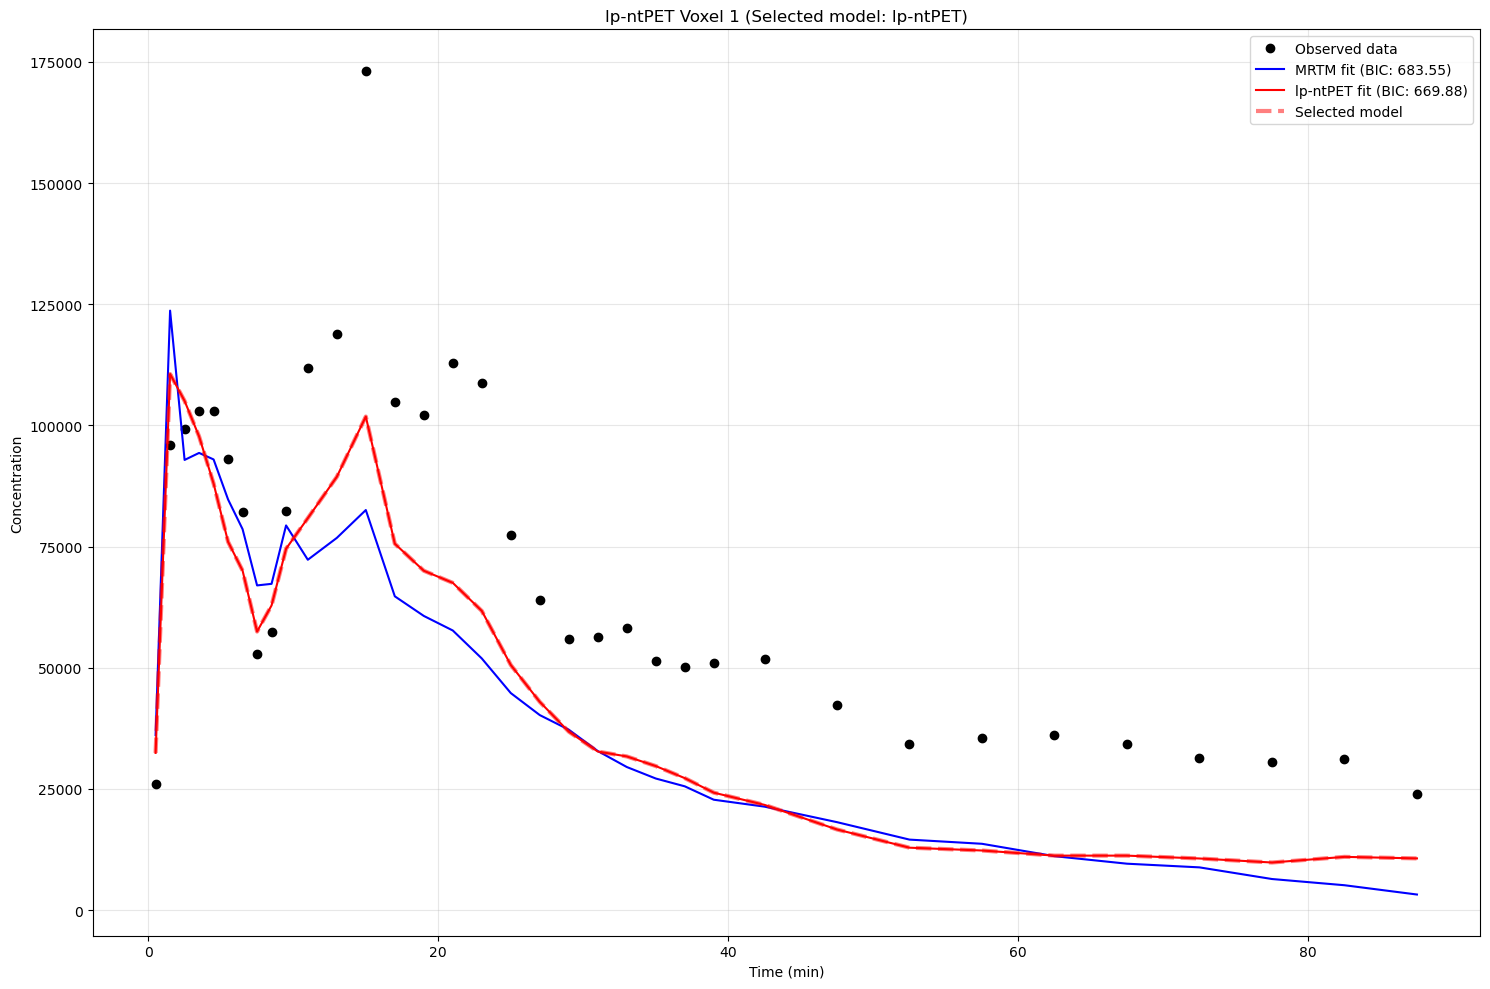


lp-ntPET Voxel 1 (Selected Model: lp-ntPET):
  MRTM parameters (R1, k2, k2a): [0.70960648 0.2255359  0.08575139]
  lp-ntPET parameters (R1, k2, k2a, gamma, alpha, tD, tP): [ 1.09958879 -1.32977429 -1.60372132  1.40926669  0.25        2.5
 48.75      ]
  RSS for MRTM: 7824787936.865152
  RSS for lp-ntPET: 3527086266.730945
  BIC for MRTM: 683.55
  BIC for lp-ntPET: 669.88
  p-value for gamma: 0.000001


In [32]:
# Select a voxel to visualize
voxel_idx = 1
if voxel_idx in lp_nt_voxels:
    true_model = "lp-ntPET"
else:
    true_model = "MRTM"
voxel_idx = voxel_idx - 1

plt.figure(figsize=(15, 10))

# Get actual data for this voxel
Ct = Cts[voxel_idx]

# Get MRTM parameters and fitted values
mrtm_params = params_MRTM[voxel_idx]
thetas = np.concatenate((mrtm_params, [np.nan, np.nan, np.nan, np.nan]))
mrtm_fitted = get_curve(Ct, Cr, ts, thetas)

# Get lp-ntPET parameters and fitted values
lpnt_params = params_lp_nt[voxel_idx]
thetas = lpnt_params
lpnt_fitted = get_curve(Ct, Cr, ts, thetas)
# lpnt_fitted = pred_lp_nt[voxel_idx]
# lpnt_fitted = pred_array

# Determine which model was selected based on BIC
selected_model = model[voxel_idx]

# Create subplot
plt.plot(ts, Ct, 'ko', label='Observed data')
plt.plot(ts, mrtm_fitted, 'b-', label=f'MRTM fit (BIC: {BIC_MRTM[voxel_idx]:.2f})')
plt.plot(ts, lpnt_fitted, 'r-', label=f'lp-ntPET fit (BIC: {BIC_lp_nt[voxel_idx]:.2f})')

# Highlight the selected model
if selected_model == "MRTM":
    plt.plot(ts, mrtm_fitted, 'b--', linewidth=3, alpha=0.5, label='Selected model')
else:
    plt.plot(ts, lpnt_fitted, 'r--', linewidth=3, alpha=0.5, label='Selected model')

plt.title(f'{true_model} Voxel {voxel_idx + 1} (Selected model: {selected_model})')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print parameter values for the selected voxels
print(f"\n{true_model} Voxel {voxel_idx + 1} (Selected Model: {selected_model}):")
print(f"  MRTM parameters (R1, k2, k2a): {params_MRTM[voxel_idx]}")
print(f"  lp-ntPET parameters (R1, k2, k2a, gamma, alpha, tD, tP): {params_lp_nt[voxel_idx]}")
print(f"  RSS for MRTM: {rss_MRTM[voxel_idx]}")
print(f"  RSS for lp-ntPET: {rss_lp_nt[voxel_idx]}")
print(f"  BIC for MRTM: {BIC_MRTM[voxel_idx]:.2f}")
print(f"  BIC for lp-ntPET: {BIC_lp_nt[voxel_idx]:.2f}")
print(f"  p-value for gamma: {p_values[voxel_idx]:.6f}")